In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import window
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType, DoubleType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import re
import os
import time
import shutil
import threading

SPARK_MASTER = "local[*]"
SPARK_APP_NAME = "dataframes"

spark_session = SparkSession.builder.master(SPARK_MASTER).appName(SPARK_APP_NAME).getOrCreate()

sc = spark_session.sparkContext
sc

## Globals

In [ ]:
# Path that the CVSs will be copied to to simulate streaming.
STREAMING_INPUT_PATH = f"stream-data{os.sep}"

SCHEMA = StructType([
    StructField("vendor_id", StringType(), True),
    StructField("pickup_datetime", TimestampType(), True),
    StructField("dropoff_datetime", TimestampType(), True),
    StructField("passenger_count", IntegerType(), True),
    StructField("trip_distance", DoubleType(), True),
    StructField("payment_type", StringType(), True),
    StructField("fare_amount", DoubleType(), True),
    StructField("tip_amount", DoubleType(), True)
])

In [ ]:
df = spark_session.read.csv("data/*.csv", schema=SCHEMA)

df.show()

## Static queries

#### Give an overview of the number of taxi rides that started between every 2 consecutive hours of a day
We make a window of every 2 hours in the pickup dates and just count the amount of entries.

In [34]:
amount_of_rides = df.groupBy(
    window(df.pickup_datetime, "2 Hour")
).count().orderBy("window")

amount_of_rides.head()

Row(window=Row(start=datetime.datetime(2013, 12, 31, 23, 0), end=datetime.datetime(2014, 1, 1, 1, 0)), count=6177)

Showing only the first 50 entries, otherwhise the graph becomes unreadable.

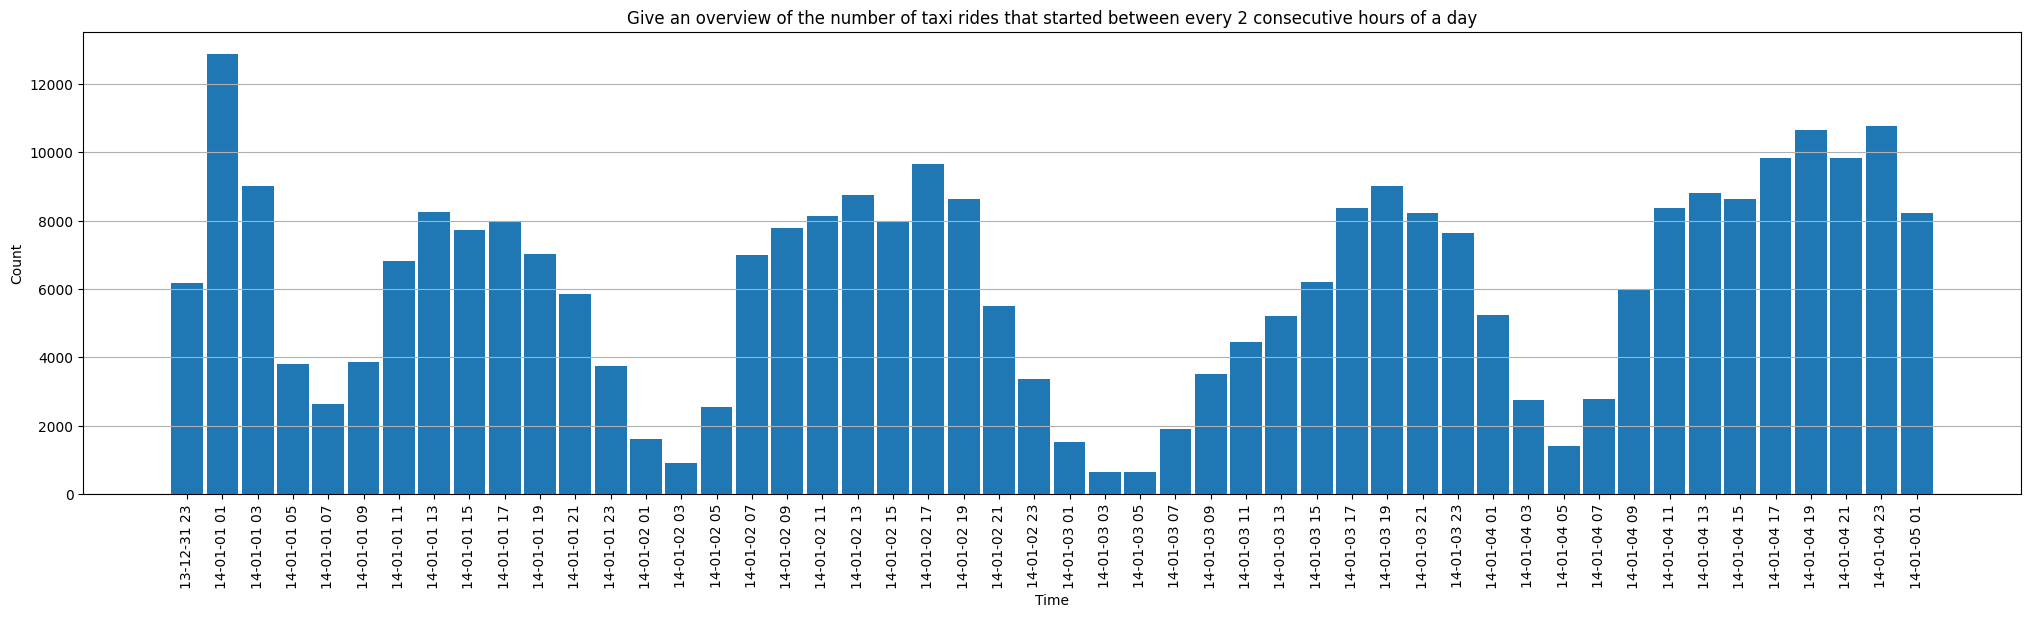

In [ ]:
pd_df = amount_of_rides.toPandas()[:50]

# Formatting the date to make it more readable
data = [w.start.strftime('%y-%m-%d %H') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['count'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Give an overview of the number of taxi rides that started between every 2 consecutive hours of a day')
plt.show()

#### Per hour per day give an overview of how many rides had 1 passenger, 2 passengers, 3 passengers, ...
This time we use aggregate to count together the amount of rows with X passenger_count in the window.

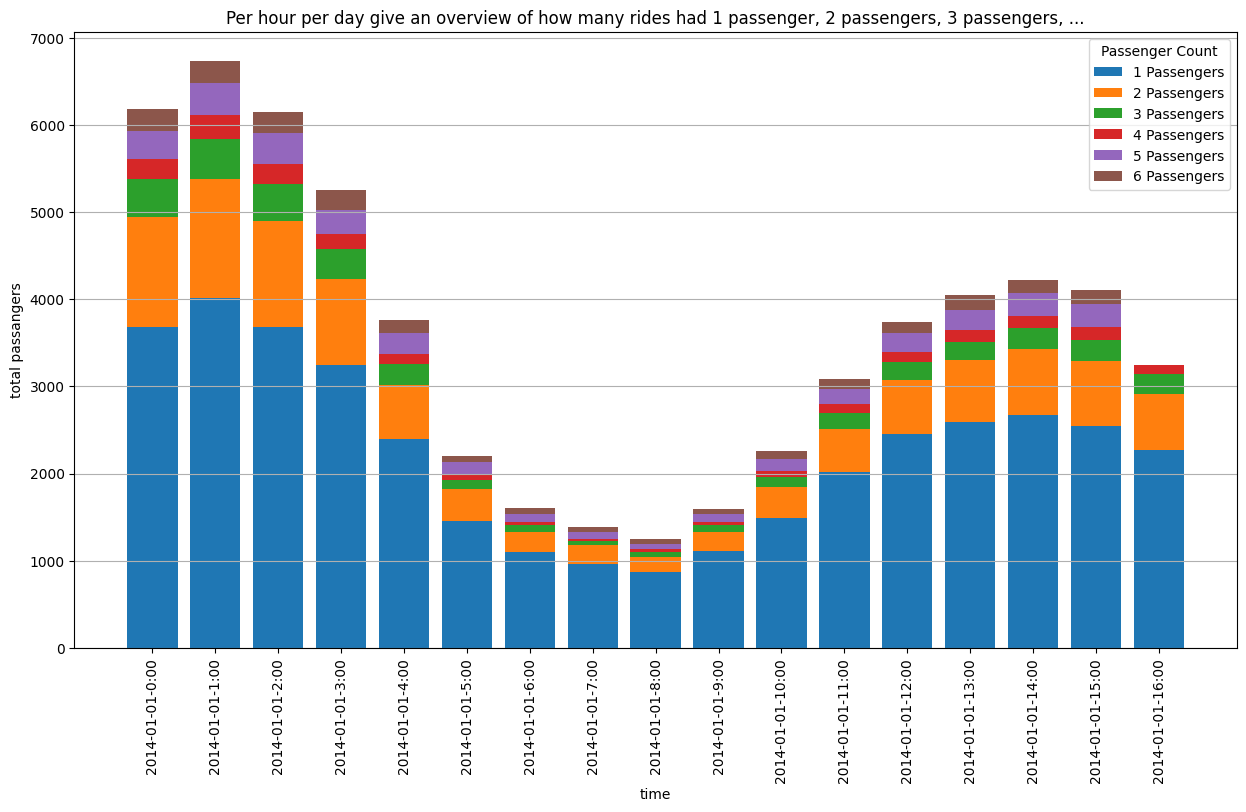

In [ ]:
amount_of_rides = df.groupBy(
    window(df.pickup_datetime, "1 hour"),
    df.passenger_count
).agg(
    F.count("passenger_count").alias("passenger_occurrences")
).orderBy("window", "passenger_count")

pd_df = amount_of_rides.toPandas()[:100]

pd_df['hour'] = pd_df['window'].apply(lambda x: x.start.hour)
pd_df['day'] = pd_df['window'].apply(lambda x: x.start.date())

# Pivot the dataframe by day and hour to get all passenger_count sums in 1 row per combination.
pivot_df = pd_df.pivot_table(
    index=['day', 'hour'], columns='passenger_count', values='passenger_occurrences', fill_value=0, 
)

labels = [f'{day}-{hour}:00' for day, hour in pivot_df.index]

fig, ax = plt.subplots(figsize=(15, 8))

# To flip the order of passenger_count per bar
bottom = np.zeros(len(pivot_df))

# For stacked bar graphs, the bars have to be made individualy.
for passenger_count in pivot_df.columns:
    ax.bar(
        labels, pivot_df[passenger_count], bottom=bottom, label=f'{passenger_count} Passengers'
    )
    bottom += pivot_df[passenger_count].values

plt.xticks(rotation=90)
plt.xlabel('time')
plt.ylabel('total passangers')
plt.title('Per hour per day give an overview of how many rides had 1 passenger, 2 passengers, 3 passengers, ...')
plt.grid(axis="y")
plt.legend(title="Passenger Count")
plt.show()

#### Per hour/day the average fare amount of the rides

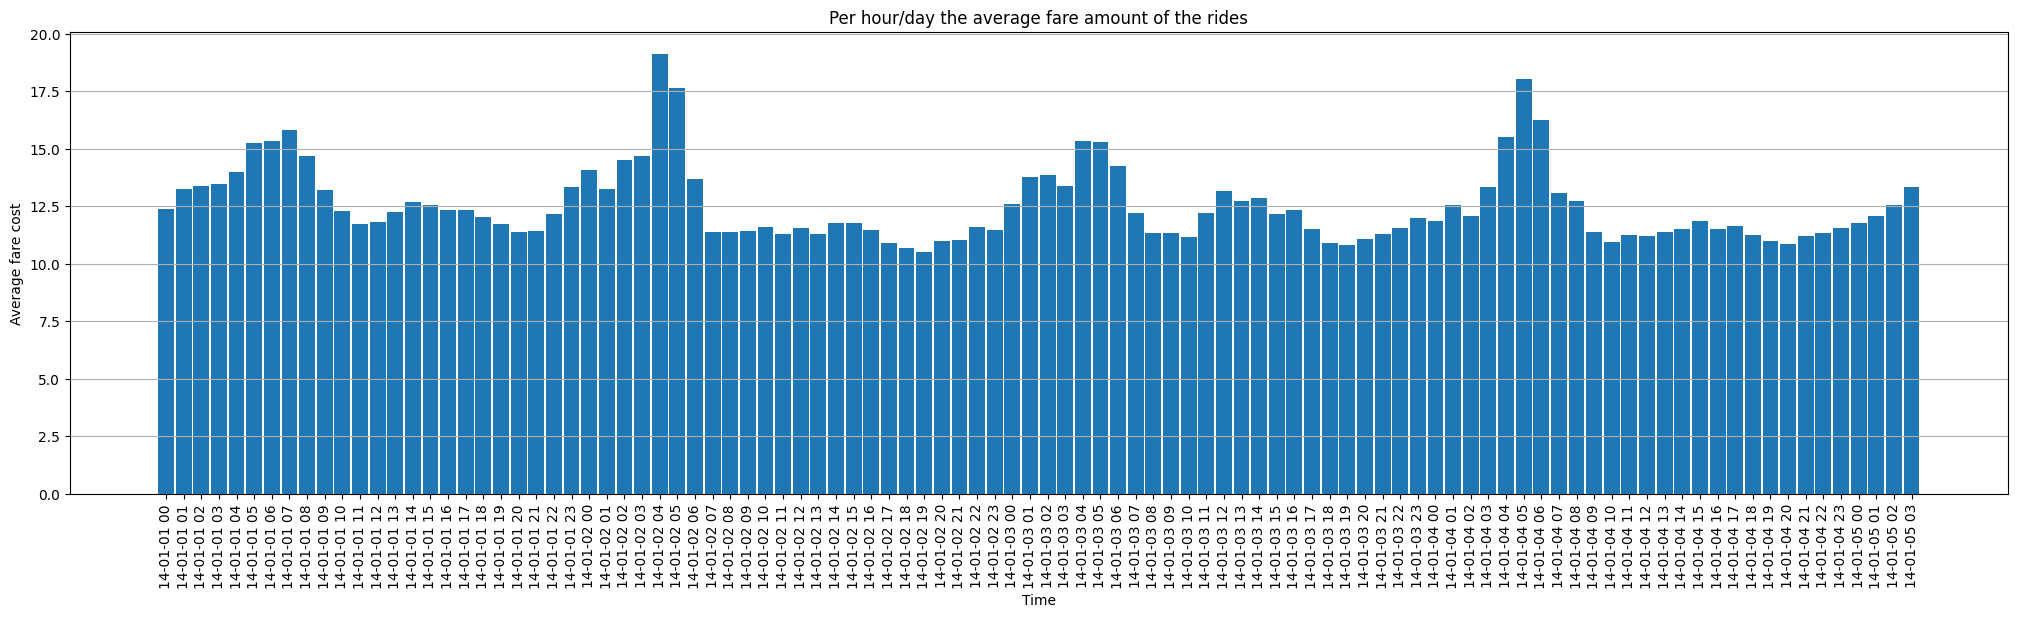

In [31]:
# Amount of hours shown, having this too high makes the graph unreadable
truncate_amount = 100

amount_of_rides = df.groupBy(
    window(df.pickup_datetime, "1 hour"),
).agg(
    F.avg("fare_amount").alias("average_fare_amount")
).orderBy("window")

pd_df = amount_of_rides.toPandas()[:truncate_amount]

data = [w.start.strftime('%y-%m-%d %H') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['average_fare_amount'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Average fare cost')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Per hour/day the average fare amount of the rides')
plt.show()

#### Per hour/day the number of rides in which a tip of more than 10 percent was given.
This time we need a When in the aggregate to check if the amount is more than 10%. It returns either the Column or None whereby None is not counted.

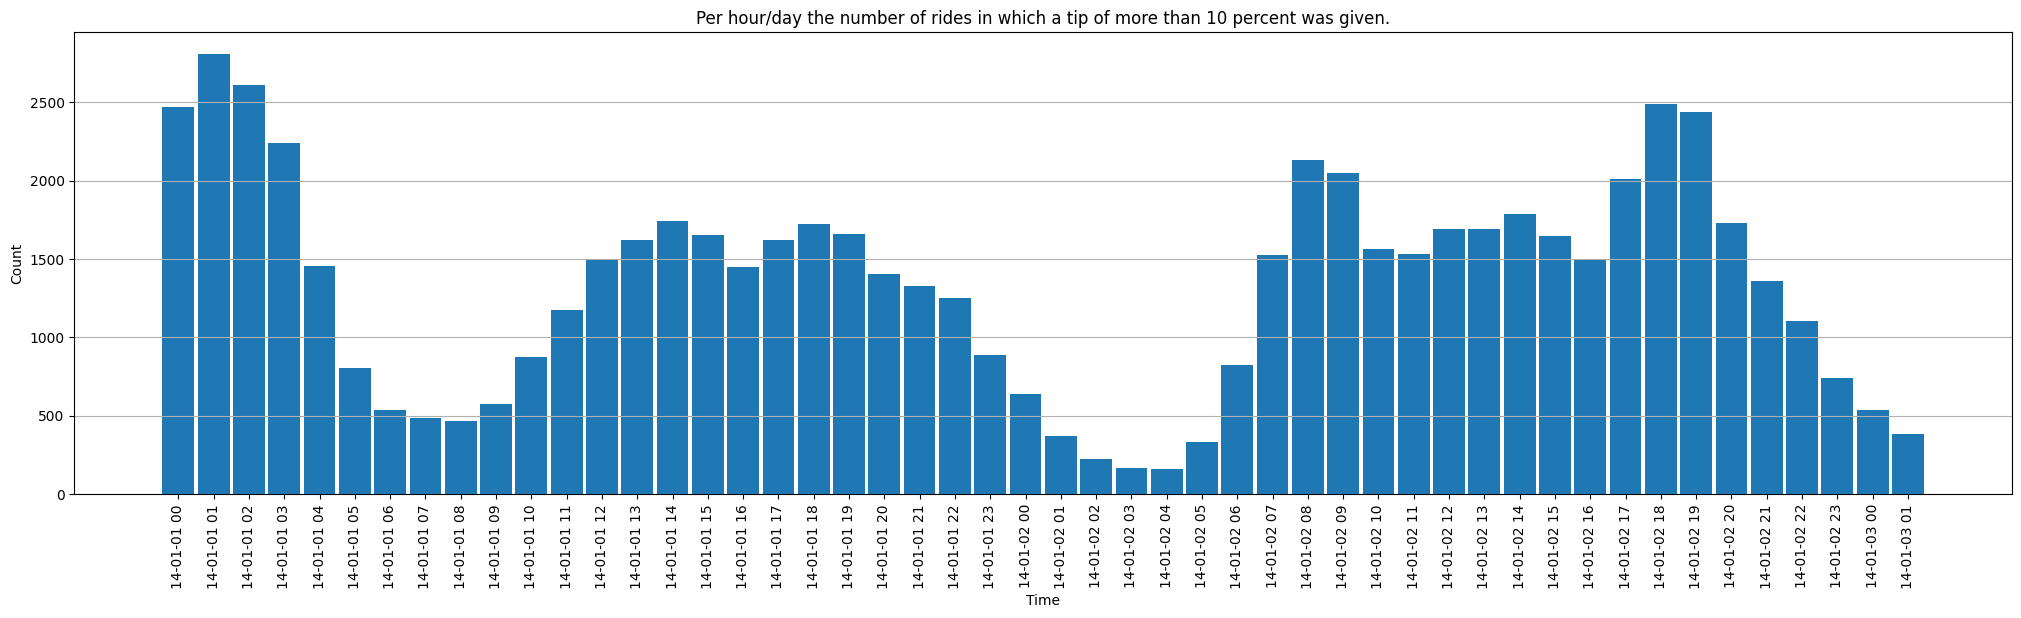

In [30]:
amount_of_rides = df.groupBy(
    window(df.pickup_datetime, "1 Hour")
).agg(
    F.count(
        F.when(F.col("tip_amount") >= (0.1 * F.col("fare_amount")), True)
    ).alias("tip_count")
).orderBy("window")

pd_df = amount_of_rides.toPandas()[:50]

data = [w.start.strftime('%y-%m-%d %H') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['tip_count'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Per hour/day the number of rides in which a tip of more than 10 percent was given.')
plt.show()

#### Per hour/day the sum of tips of the rides

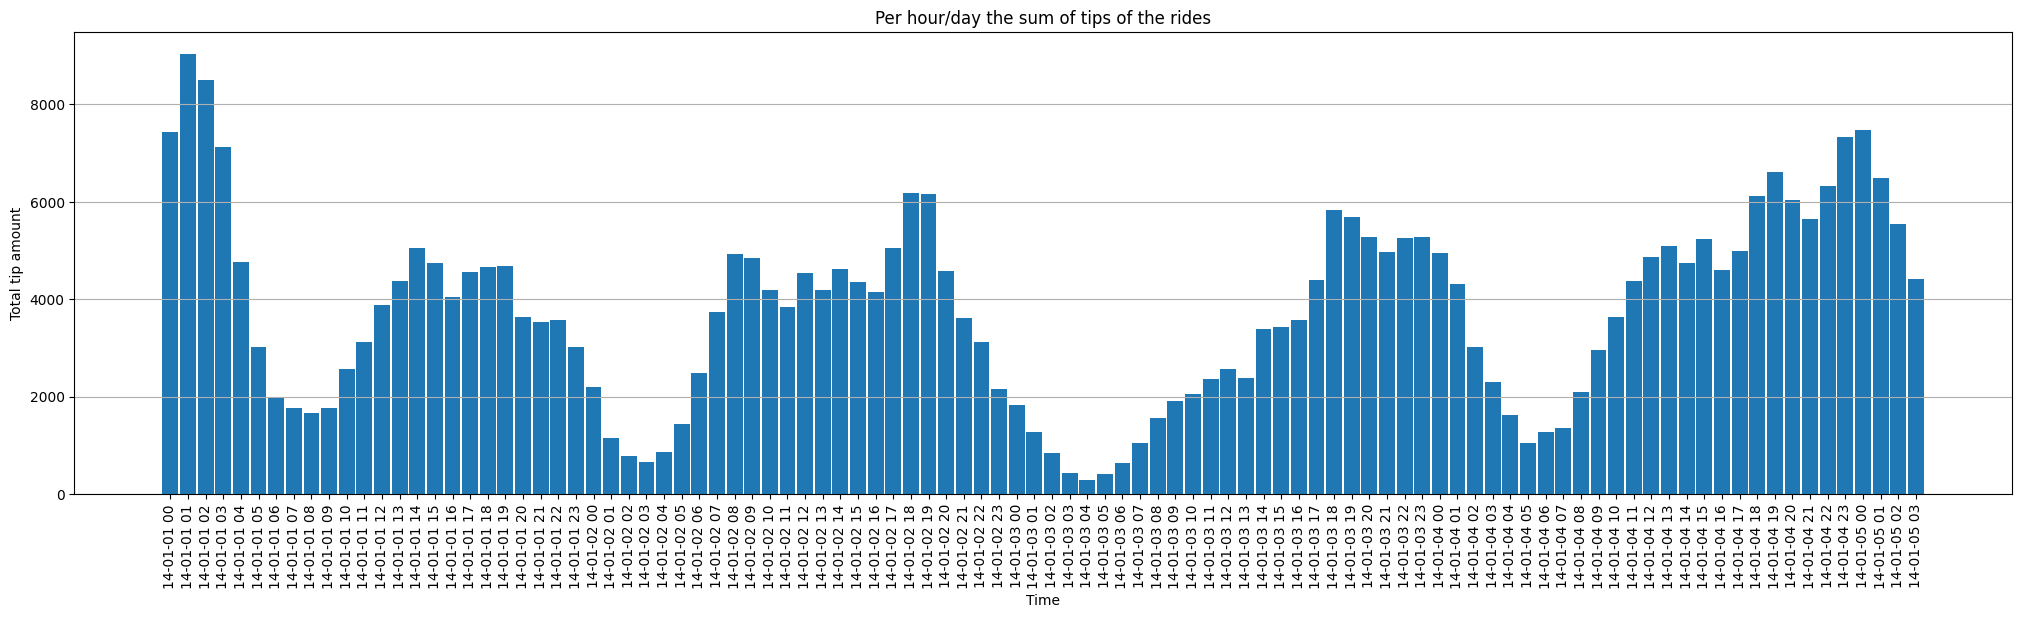

In [ ]:
truncate_amount = 100

amount_of_rides = df.groupBy(
    window(df.pickup_datetime, "1 hour"),
).agg(
    F.sum("tip_amount").alias("tip_amount")
).orderBy("window")

pd_df = amount_of_rides.toPandas()[:truncate_amount]

data = [w.start.strftime('%y-%m-%d %H') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['tip_amount'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Total tip amount')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Per hour/day the sum of tips of the rides')
plt.show()

#### Per day the sum of fare of the rides

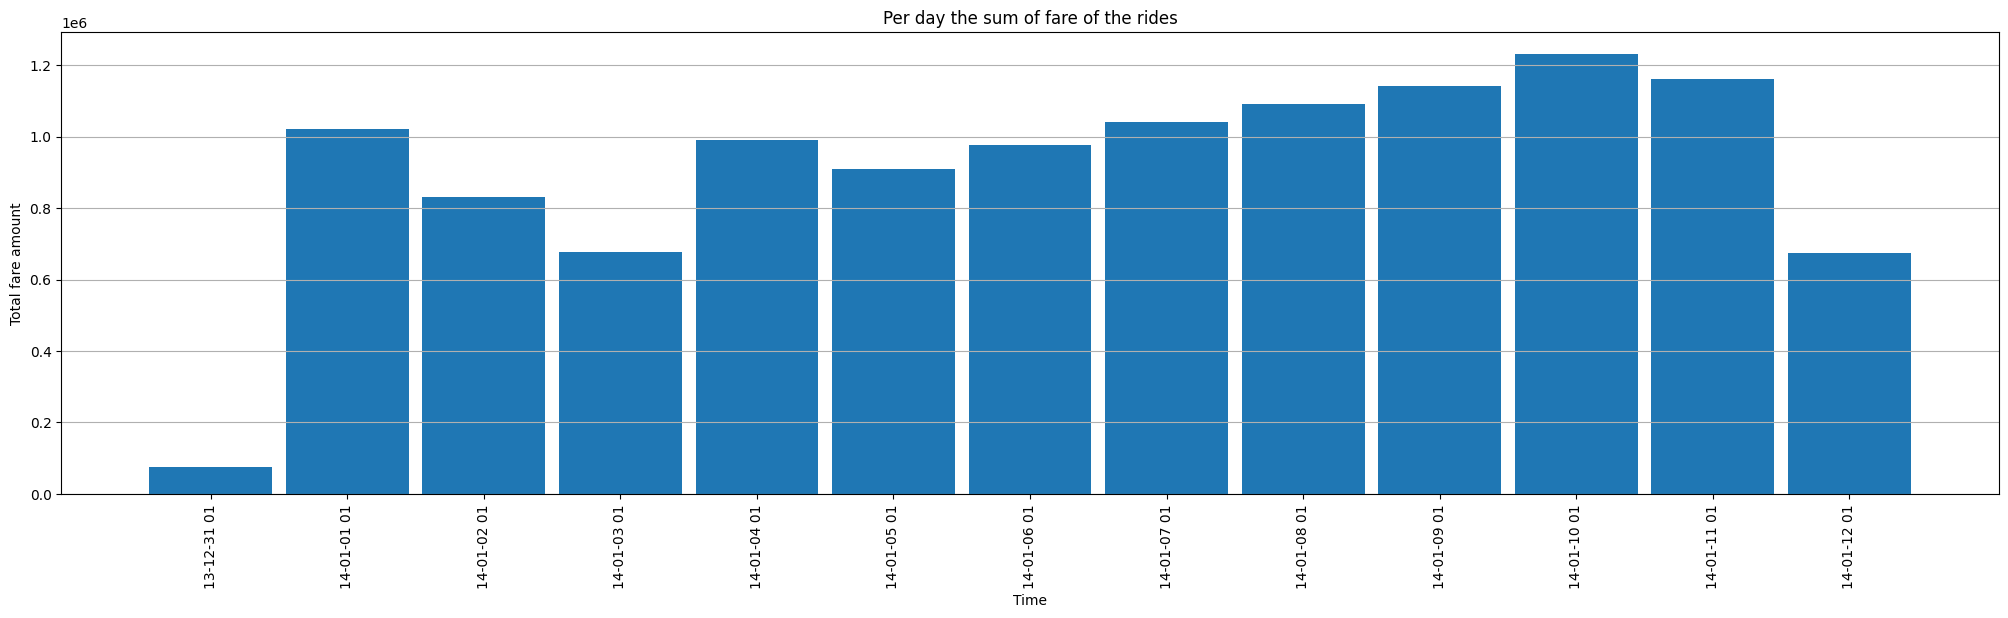

In [28]:
amount_of_rides = df.groupBy(
    window(df.pickup_datetime, "1 day"),
).agg(
    F.sum("fare_amount").alias("fare_amount")
).orderBy("window")

pd_df = amount_of_rides.toPandas()

data = [w.start.strftime('%y-%m-%d %H') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['fare_amount'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Total fare amount')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Per day the sum of fare of the rides')
plt.show()

## Streaming queries

#### Streaming simulation

batch_loop copies the CSV files to simulate data coming in. It then gets called in its own thread so queries can run simultaniously.

In [ ]:
def batch_loop():
    csv_paths = []
    data_path = "data"
    stream_path = "stream-data"

    # Delete copied files from previous runs.
    for file_name in os.listdir(stream_path):
        if file_name.endswith(".csv"):
            os.remove(os.path.join(stream_path, file_name))

    for file_name in os.listdir(data_path):
        if file_name.endswith(".csv"):
            csv_paths.append(os.path.join(data_path, file_name))


    batch_size = 5
    seconds_between_batches = 5
    while len(csv_paths) != 0:
        csv_paths_batch = csv_paths[:batch_size]
        csv_paths = csv_paths[batch_size:]

        for path in csv_paths_batch:
            shutil.copy(path, stream_path)

        # time.sleep(seconds_between_batches)

batch_thread = threading.Thread(target=batch_loop)
batch_thread.start()
batch_thread.join()

# Wait for stream to process the csvs
time.sleep(6)

#### Give an overview of the number of taxi rides that started between every 2 consecutive hours of a day

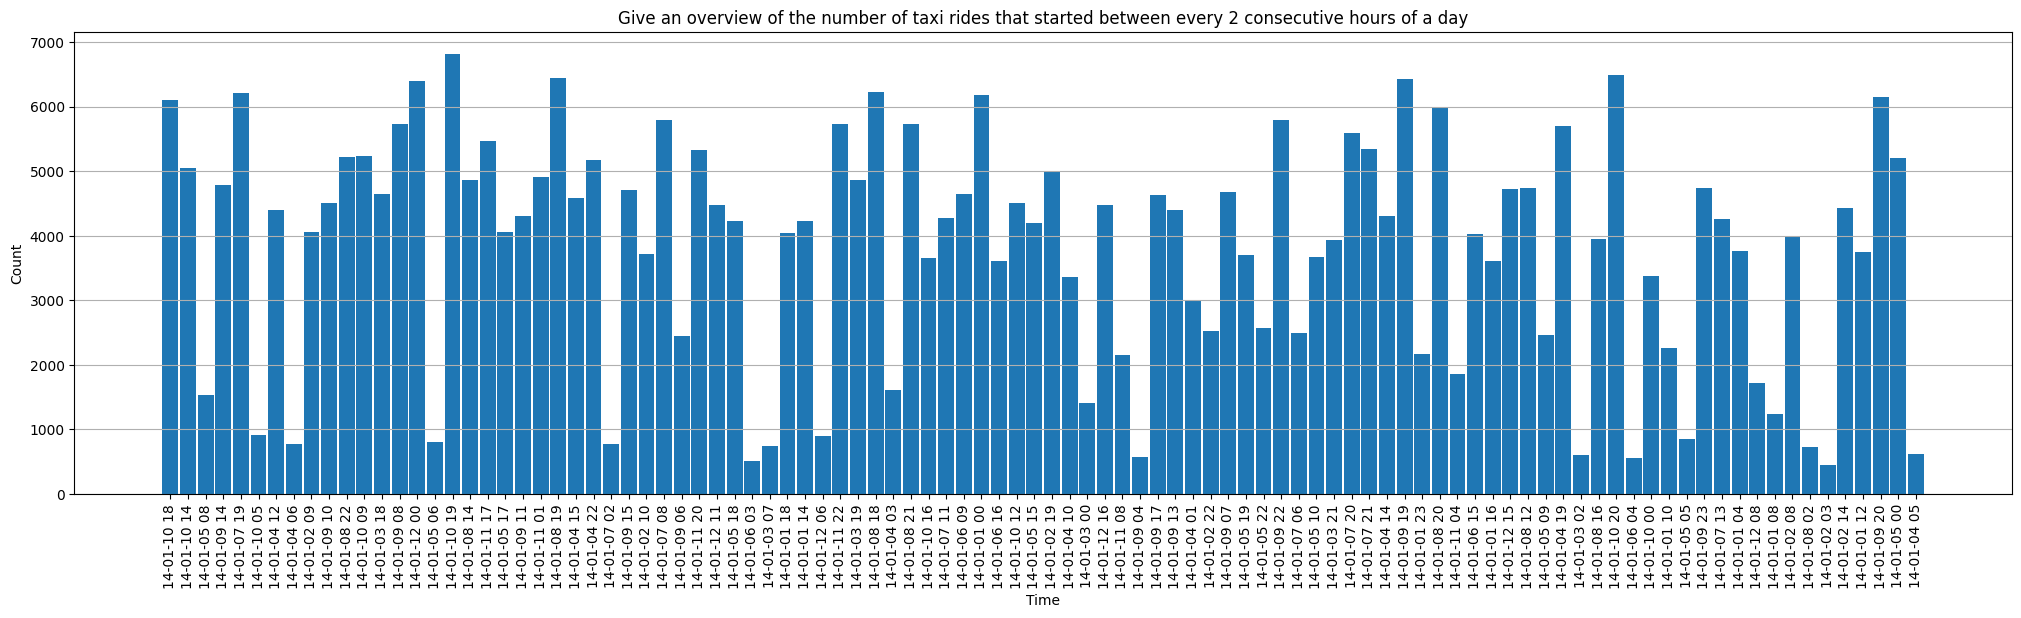

In [ ]:
# We read the stream saying the input will be CSV files in the STREAMING_INPUT_PATH folder.
# maxFilesPerTrigger is set to 1 for easier debugging. But it should also work without.
streaming_input_df = (
  spark_session
    .readStream                       
    .schema(SCHEMA)
    .option("maxFilesPerTrigger", 1)
    .csv(STREAMING_INPUT_PATH)
)

streaming_counts_df = (                 
  streaming_input_df
    .groupBy(
      window(streaming_input_df.pickup_datetime, "1 hour"))
    .count()
)

# Write the output to memory. For ease, recalculate the results each time.
query = (
  streaming_counts_df
    .writeStream
    .format("memory")
    .queryName("counts")
    .outputMode("complete")
    .start()
)

counts_df = spark_session.sql("SELECT * FROM counts")

pd_df = counts_df.toPandas()[:100]

data = [w.start.strftime('%y-%m-%d %H') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['count'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Give an overview of the number of taxi rides that started between every 2 consecutive hours of a day')
plt.show()

#### Per 2 hours an overview of how many rides had 1 passenger, 2 passengers, 3 passengers, which will be updated every hour. So for every hour you see the number of taxi rides of the last 2 hours
Mostly the same as the static version. The first use of sliding windows.

In [ ]:
streaming_input_df = (
  spark_session
    .readStream
    .schema(SCHEMA)
    .option("maxFilesPerTrigger", 1)
    .csv(STREAMING_INPUT_PATH)
)

# 1 hour sliding windows spanning back 2 hours.
streaming_counts_df = streaming_input_df.groupBy(
    window(streaming_input_df.pickup_datetime, windowDuration="2 hour", slideDuration="1 hour"),
    streaming_input_df.passenger_count
).agg(
    F.count("passenger_count").alias("passenger_occurrences")
).orderBy("window", "passenger_count")

query = (
  streaming_counts_df
    .writeStream
    .format("memory")
    .queryName("passenger_counts")
    .outputMode("complete")
    .start()
)

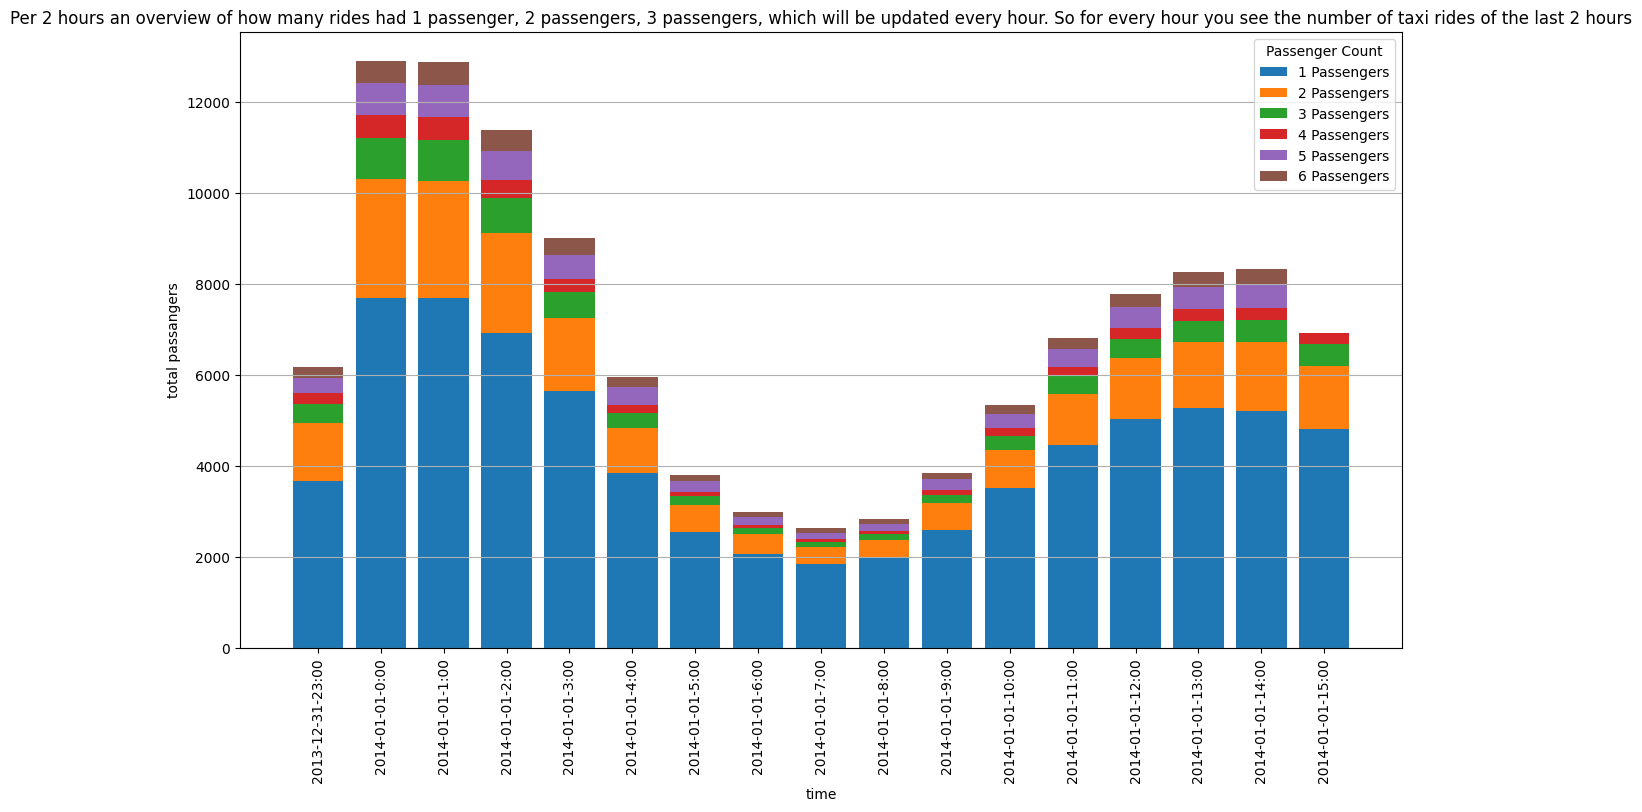

In [ ]:
counts_df = spark_session.sql("SELECT * FROM passenger_counts")

pd_df = counts_df.toPandas()[:100]

pd_df['hour'] = pd_df['window'].apply(lambda x: x.start.hour)
pd_df['day'] = pd_df['window'].apply(lambda x: x.start.date())

pivot_df = pd_df.pivot_table(
    index=['day', 'hour'], columns='passenger_count', values='passenger_occurrences', fill_value=0, 
)

labels = [f'{day}-{hour}:00' for day, hour in pivot_df.index]

fig, ax = plt.subplots(figsize=(15, 8))

bottom = np.zeros(len(pivot_df))

for passenger_count in pivot_df.columns:
    ax.bar(
        labels, pivot_df[passenger_count], bottom=bottom, label=f'{passenger_count} Passengers'
    )
    bottom += pivot_df[passenger_count].values

plt.xticks(rotation=90)
plt.xlabel('time')
plt.ylabel('total passangers')
plt.title('Per 2 hours an overview of how many rides had 1 passenger, 2 passengers, 3 passengers, which will be updated every hour. So for every hour you see the number of taxi rides of the last 2 hours')
plt.grid(axis="y")
plt.legend(title="Passenger Count")
plt.show()

#### Per hour/day the average fare amount of the rides

In [ ]:
streaming_input_df = (
  spark_session
    .readStream
    .schema(SCHEMA)
    .option("maxFilesPerTrigger", 1)
    .csv(STREAMING_INPUT_PATH)
)

streaming_counts_df = streaming_input_df.groupBy(
    window(streaming_input_df.pickup_datetime, windowDuration="1 hour"),
    streaming_input_df.fare_amount
).agg(
    F.mean("fare_amount").alias("average_fare")
).orderBy("window")

query = (
  streaming_counts_df
    .writeStream
    .format("memory")
    .queryName("average_fare")
    .outputMode("complete")
    .start()
)

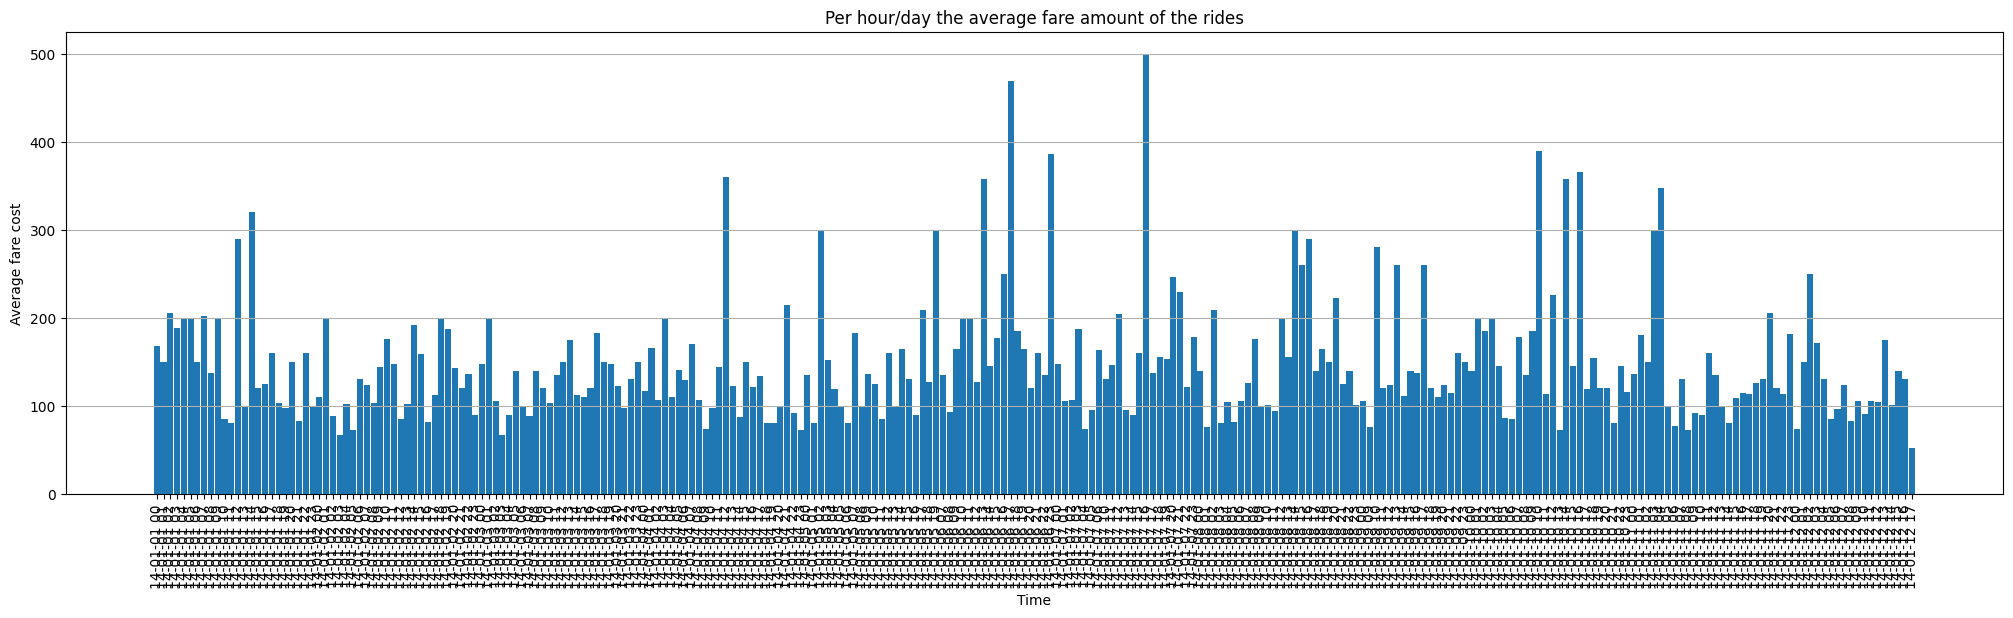

In [25]:
average_fare = spark_session.sql("SELECT * FROM average_fare")

pd_df = average_fare.toPandas()

data = [w.start.strftime('%y-%m-%d %H') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['average_fare'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Average fare cost')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Per hour/day the average fare amount of the rides')
plt.show()

#### Per hour the number of rides that were less than 2 miles long
A filter is used to make sure the entries have a trip distance of less than 2 miles.

In [ ]:
streaming_input_df = (
  spark_session
    .readStream
    .schema(SCHEMA)
    .option("maxFilesPerTrigger", 1)
    .csv(STREAMING_INPUT_PATH)
)

streaming_short_rides_df = streaming_input_df.filter(streaming_input_df.trip_distance < 2)
streaming_counts_df = streaming_short_rides_df.groupBy(
    window(streaming_short_rides_df.pickup_datetime, "1 hour")
).count().orderBy("window")

query = (
    streaming_counts_df
    .writeStream
    .format("memory")
    .queryName("short_ride_counts")
    .outputMode("complete")
    .start()
)

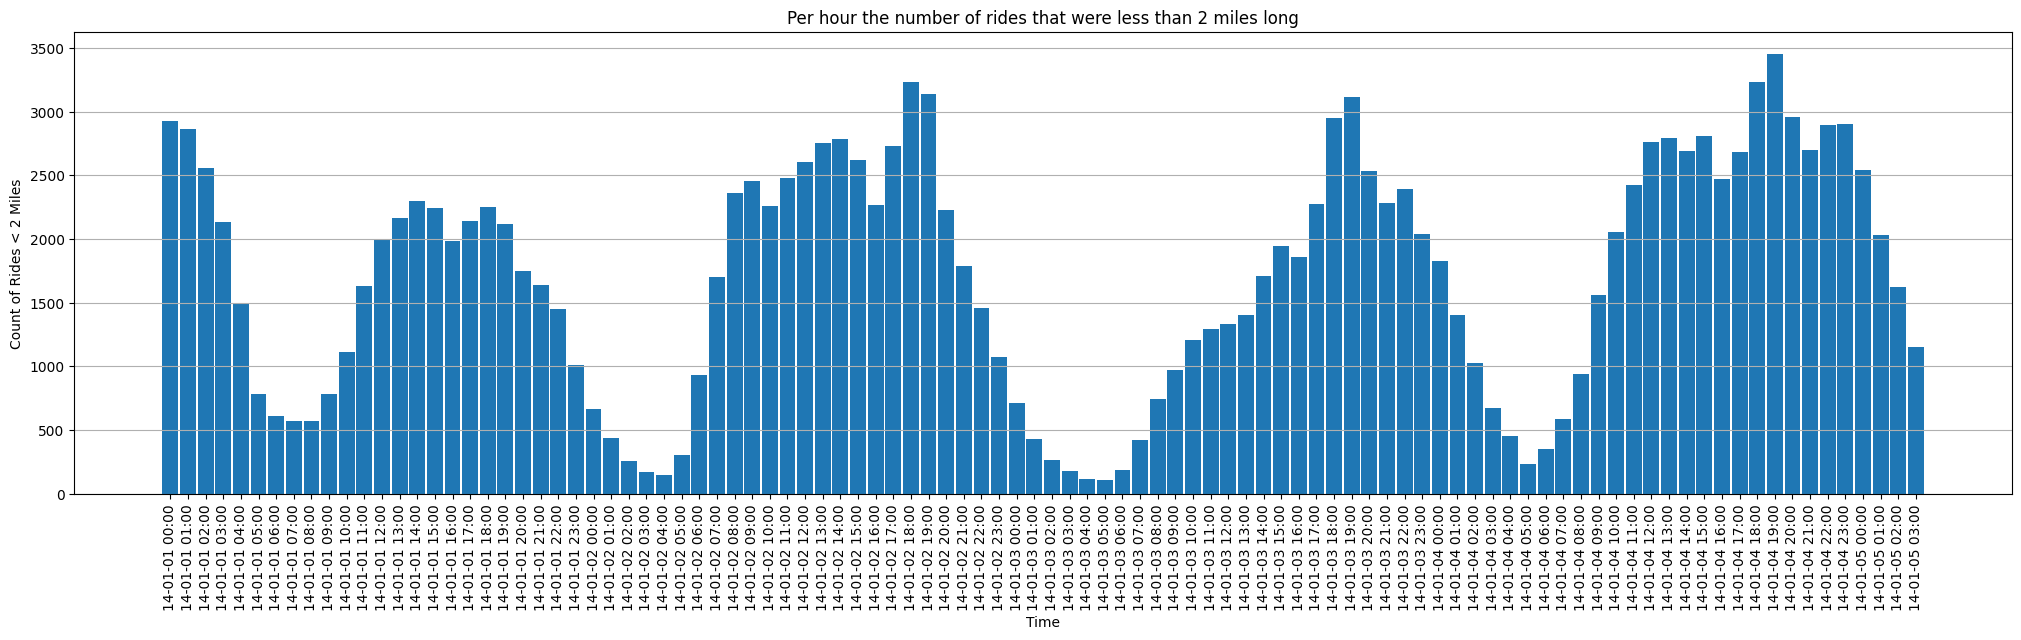

In [ ]:
counts_df = spark_session.sql("SELECT * FROM short_ride_counts")

pd_df = counts_df.toPandas()[:100]
data = [w.start.strftime('%y-%m-%d %H:%M') for w in pd_df['window']]

plt.figure(figsize=(25,6))
plt.bar(data, pd_df['count'], width=0.9)
plt.xlabel('Time')
plt.ylabel('Count of Rides < 2 Miles')
plt.xticks(rotation=90)
plt.grid(axis="y")
plt.title('Per hour the number of rides that were less than 2 miles long')
plt.show()

## Cleanup
Stops the Spark session.

In [ ]:
spark_session.stop()